In [3]:
import numpy as np
import pymatching
import networkx
import sys
import stim

# Prototype Floquet-Bacon-Shor code for a 3x3 lattice

 Code is a work in progress and the decoder is still shaky. It currently is generating a decoding hypergraph due to creating gauge detectors instead of combining gauge measurements to track one stabilizer. Nonetheless it runs and decodes somewhat effectively.

## Specify the circuit

In [783]:
ITERATIONS = 4
SHOTS = 10
Noisy = False
IDF = False
output = 'sample_detector'
printout = False
Tune = False

### ERROR MODEL ###################
single_xz_error = 0.01
single_gate_error = 0.0007
px = 0.007
pz = 0
px = 0.014
ancilla_readout_error = 0.0158
error_qubit = [0,1,2,3,4,5,6,7,8]
DC = True
#DC_Type = 'defect_stabilizers'
DC_Type = 'gauge_checks'
itr = 0
rndx = 3 # must be 1 or 3  ( = (4*itr + rnd) mod 4 )
rndz = 0 # must be 0 or 2  ( = (4*itr + rnd) mod 4 )
################################

steps = 4*ITERATIONS



qubit = [0,1,2,3,4,5,6,7,8]


ancilla = [0,1,2,3,4,5,6,7]+len(qubit)*np.ones(8).astype(int)
encoded_utility_ancillas = np.arange(np.max(ancilla)+1, np.max(ancilla)+7)
logical_out = np.max(encoded_utility_ancillas)+1
boundary_detectors = []
for i in range(8):
    boundary_detectors.append(logical_out+1+i)


gauge_checks_X_A = [(1,4),(3,6),(4,7),(5,8)]
gauge_checks_Z_B = [(1,2),(3,4),(4,5),(7,8)]
gauge_checks_X_C = [(0,3),(1,4),(2,5),(4,7)]
gauge_checks_Z_D = [(0,1),(3,4),(4,5),(6,7)]
schedule = [gauge_checks_X_A, gauge_checks_Z_B, gauge_checks_X_C, gauge_checks_Z_D]

ancilla_idx = [(0,1,2,3), (4,5,6,7), (0,1,2,3), (4,5,6,7)]
logical_Z = [(0,2), (6,7), (6,8), (7,8)]
logical_X = [(0,3), (0,6), (3,6), (2,8)]

logical_Z_thermalized = [1,4,7]
logical_X_thermalized = [3,4,5]

Z_sd = [logical_Z_thermalized,logical_Z]

thermalized_logicals = [logical_X_thermalized,logical_Z_thermalized]









## Build the circuit

In [784]:


qc = stim.Circuit()

FBS_circuit = stim.Circuit()


for i in range(16):
    FBS_circuit.append("M", 0)
    FBS_circuit.append("R", 0)



for i in range(4):
    if Noisy == Tune and  (i == rndx or i == rndx + 2) :
        qc.append('X_ERROR',error_qubit,px)

    if Noisy == Tune and (i == rndz or i == rndz + 2):
        qc.append('Z_ERROR',error_qubit,pz)


    anc_values = [ancilla[count] for count in ancilla_idx[i]]

    if i%2 == 0:   
        qc.append('H',anc_values)
        

    for j in range(4):
        for t in range(2):
            qubit_value = schedule[i][j][t]

            qc.append('CNOT', [qubit_value , anc_values[j]])


    if i%2 == 0:   
        qc.append('H',anc_values)
        


    for j in anc_values:

        qc.append('M', j)
        if Noisy == True:
            qc.append('X_ERROR', j, ancilla_readout_error)
        qc.append('R', j)

    

    if DC_Type == 'defect_stabilizers':   
        
        qc.append("DETECTOR", [stim.target_rec(-1),stim.target_rec(-2),stim.target_rec(-3),stim.target_rec(-4),stim.target_rec(-17),stim.target_rec(-18),stim.target_rec(-19),stim.target_rec(-20)])

        


    if DC_Type == 'gauge_checks':

        qc.append("DETECTOR", [stim.target_rec(-1),stim.target_rec(-17)])
        qc.append("DETECTOR", [stim.target_rec(-2),stim.target_rec(-18)])
        qc.append("DETECTOR", [stim.target_rec(-3),stim.target_rec(-19)])
        qc.append("DETECTOR", [stim.target_rec(-4),stim.target_rec(-20)])

                
    qc.append("TICK") 
    
qc.append('SHIFT_COORDS', [], arg = [0,0,1])
    

FBS_circuit.append(stim.CircuitRepeatBlock(body = qc, repeat_count = ITERATIONS))
FBS_circuit.append('M', [1,4,7])
FBS_circuit.append('M', [7,8])
FBS_circuit.append('OBSERVABLE_INCLUDE',[stim.target_rec(-3),stim.target_rec(-4),stim.target_rec(-5)],0)
FBS_circuit.append('OBSERVABLE_INCLUDE',[stim.target_rec(-1),stim.target_rec(-2)],1)





## Extract the error model and run the experiment SHOTS times

In [785]:
dem = FBS_circuit.detector_error_model(decompose_errors=True, allow_gauge_detectors=True)
m = pymatching.Matching.from_detector_error_model(dem)

detector_sampler = FBS_circuit.compile_detector_sampler()
detector_samples, observables = FBS_circuit.compile_detector_sampler().sample(shots=SHOTS, separate_observables=True)

## Output the measured Z_s,Z_d, corrections, and corrected Z_s,Z_d.

In [786]:

corrections = m.decode_batch(detector_samples)
observable_results = observables.astype(int)^corrections


MO = ' '.join([f"[{x[0]} {x[1]}]" for x in observables.astype(int)])
C  = ' '.join([f"[{x[0]} {x[1]}]" for x in corrections.astype(int)])
CO = ' '.join([f"[{x[0]} {x[1]}]" for x in observable_results])


print('OBSERVABLES  =======> [Z_s,Z_d]')
print('----------------------------')
print(f'measured observables:  {MO} ')
print(f'corrections:           {C}')
print(f'corrected_observables: {CO} ')

OBSERVABLES  =======> [Z_s,Z_d]
----------------------------
measured observables:  [0 1] [0 0] [0 0] [0 0] [0 0] [0 0] [1 1] [0 0] [1 0] [0 0] 
corrections:           [1 1] [0 0] [0 0] [0 0] [0 0] [0 0] [1 1] [0 0] [0 0] [0 0]
corrected_observables: [1 0] [0 0] [0 0] [0 0] [0 0] [0 0] [0 0] [0 0] [1 0] [0 0] 


Given this is a "floquet-ified" subsystem code, the decoding can be difficult. I am still currently using the gauges for detectors which is not practical as it leads to a decoding hypergraph, but properly setting up detectors from the gauge checks in stim requires more subtle thinking

## (Optional) Display the detector (hyper) graph

<pymatching.Matching object with 64 detectors, 0 boundary nodes, and 29 edges>

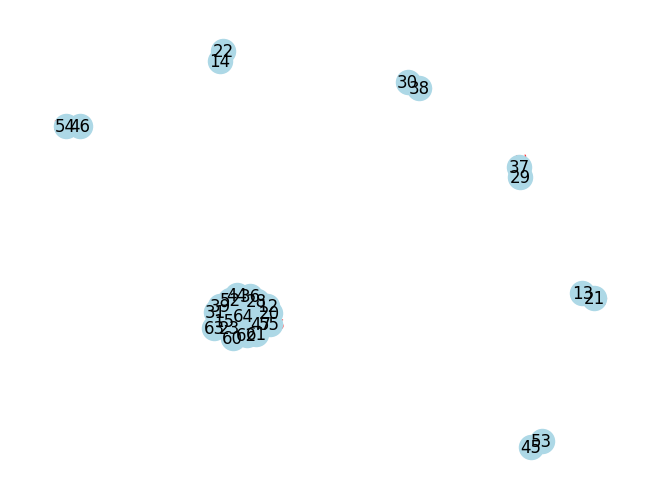

In [787]:
def visualize_graph(input_pymatching_object):

        m1 = input_pymatching_object
        G = m1.to_networkx()
        pos = networkx.spring_layout(G)
        networkx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
        networkx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}, font_color='red')

visualize_graph(m)
m